<a href="https://colab.research.google.com/github/a945120/AIProject/blob/master/AIproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/a945120/AIProject.git

Cloning into 'AIProject'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (12/12), done.
Resolving deltas: 100% (2/2), done.


In [2]:
import yfinance as yf
import pandas as pd
import os

In [36]:
predict_stock = input();

MMM


In [37]:
if os.path.exists("stock.csv"):
    stock = pd.read_csv("stock.csv", index_col=0)
else:
    stock = yf.Ticker(predict_stock)
    stock = stock.history(period="max")
    stock.to_csv("sp500.csv")

In [38]:
stock.index = pd.to_datetime(stock.index)

In [39]:
stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1962-01-02 00:00:00-05:00,0.000000,0.718673,0.697536,0.702820,212800,0.0,0.0
1962-01-03 00:00:00-05:00,0.000000,0.708104,0.690930,0.708104,422400,0.0,0.0
1962-01-04 00:00:00-05:00,0.000000,0.719994,0.708104,0.708104,212800,0.0,0.0
1962-01-05 00:00:00-05:00,0.000000,0.705462,0.686967,0.689609,315200,0.0,0.0
1962-01-08 00:00:00-05:00,0.000000,0.690930,0.681682,0.685646,334400,0.0,0.0
...,...,...,...,...,...,...,...
2024-01-17 00:00:00-05:00,106.849998,107.660004,105.529999,106.080002,2639500,0.0,0.0
2024-01-18 00:00:00-05:00,106.330002,106.739998,105.339996,106.440002,2493100,0.0,0.0
2024-01-19 00:00:00-05:00,106.739998,108.360001,105.099998,107.760002,3269500,0.0,0.0


<Axes: xlabel='Date'>

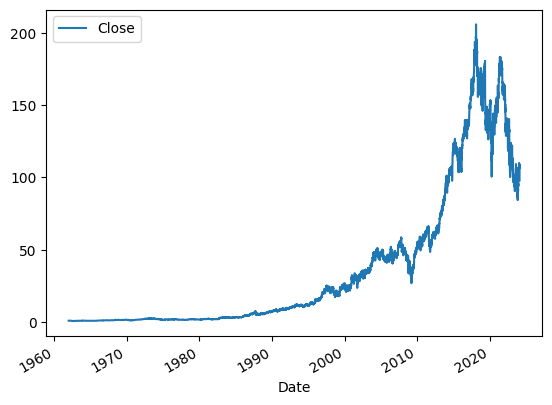

In [40]:
stock.plot.line(y="Close", use_index=True)

In [41]:
del stock["Dividends"]
del stock["Stock Splits"]

In [42]:
stock["Tomorrow"] = stock["Close"].shift(-1)

In [43]:
stock["Target"] = (stock["Tomorrow"] > stock["Close"]).astype(int)

In [44]:
stock = stock.loc["1990-01-01":].copy()

In [45]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = stock.iloc[:-100]
test = stock.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [46]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.44642857142857145

<Axes: xlabel='Date'>

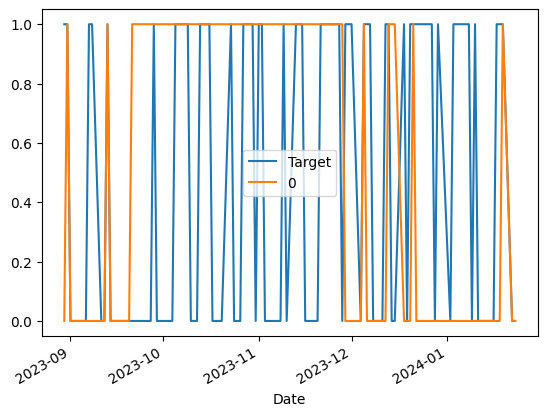

In [47]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [48]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [49]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [50]:
predictions = backtest(stock, model, predictors)

In [51]:
predictions["Predictions"].value_counts()

1    3098
0    2982
Name: Predictions, dtype: int64

In [52]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5093608779857973

In [53]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = stock.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    stock[ratio_column] = stock["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    stock[trend_column] = stock.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [54]:
stock = stock.dropna(subset=stock.columns[stock.columns != "Tomorrow"])

In [55]:
stock

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,11.641153,11.641153,11.496461,11.614845,1385200,11.759539,1,0.997740,1.0,1.011455,2.0,1.048629,26.0,1.045125,117.0,1.253294,478.0
1993-12-15 00:00:00-05:00,11.601692,11.812154,11.601692,11.759539,1896400,11.891071,1,1.006190,1.0,1.017528,2.0,1.060378,27.0,1.057668,117.0,1.268321,478.0
1993-12-16 00:00:00-05:00,11.772687,11.891071,11.733225,11.891071,1385200,11.812141,0,1.005561,2.0,1.019856,3.0,1.070639,28.0,1.069006,117.0,1.281906,478.0
1993-12-17 00:00:00-05:00,11.877911,11.943680,11.720065,11.812141,2896000,11.785835,0,0.996670,1.0,1.005373,3.0,1.061970,28.0,1.061432,117.0,1.272793,478.0
1993-12-20 00:00:00-05:00,11.812143,11.812143,11.746374,11.785835,1152800,11.575381,0,0.998885,0.0,1.001117,2.0,1.058009,28.0,1.058592,117.0,1.269386,477.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17 00:00:00-05:00,106.849998,107.660004,105.529999,106.080002,2639500,106.440002,1,0.992701,0.0,0.983935,1.0,1.067189,33.0,1.065141,112.0,0.799224,499.0
2024-01-18 00:00:00-05:00,106.330002,106.739998,105.339996,106.440002,2493100,107.760002,1,1.001694,1.0,0.990692,2.0,1.067012,34.0,1.068981,113.0,0.802139,500.0
2024-01-19 00:00:00-05:00,106.739998,108.360001,105.099998,107.760002,3269500,108.019997,1,1.006162,2.0,1.005149,2.0,1.076022,35.0,1.082499,113.0,0.812265,501.0


In [56]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [57]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [58]:
predictions = backtest(stock, model, new_predictors)

In [59]:
predictions["Predictions"].value_counts()

0.0    4539
1.0     541
Name: Predictions, dtype: int64

In [60]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5212569316081331

In [61]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.52126
0    0.47874
Name: Target, dtype: float64

In [62]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,1.0
2003-11-18 00:00:00-05:00,0,0.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,0.0
...,...,...
2024-01-17 00:00:00-05:00,1,0.0
2024-01-18 00:00:00-05:00,1,0.0
2024-01-19 00:00:00-05:00,1,0.0
